I’ve been recently brushing up on statistics and have rediscovered an interesting problem I never fully understood: *why do we divide by $n - 1$ in the unbiased variance estimator?* 

If you have no idea about what I’m talking about, here’s a summary, based on the excellent video from Khan Academy https://www.youtube.com/watch?v=KkaU2ur3Ymw&vl=en.

# The problem

Context : we have a sample of datapoints (size $n$) from a larger population (size $N$) and we want to estimate the *population* statistics from this sample.

The population has true mean $\mu$, which we estimate with the sample mean 

$$
\bar{x} = \frac{1}{n} \sum_{i=1}^n x_i.
$$

Regarding dispersion, the population has variance $\sigma^2$, which we can estimate either with the biased estimator of the variance 

$$
S_n^2 = \frac{1}{n} \sum_{i=1}^n (x_i - \bar{x})^2,
$$

or with the unbiased estimator 

$$
S_{n-1}^2 = \frac{1}{n-1} \sum_{i=1}^n (x_i - \bar{x})^2.
$$

The interesting part of the video comes in after this introduction. Suppose a population for $N=14$ and then generate samples of size $n=3$ and let’s represent the sample mean and compare it with the population mean.

# Generating samples from a population and analyzing the effect on distances

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [2]:
# let’s generate the population

N = 14
np.random.seed(12345)
population = np.random.uniform(low=0, high=10, size=N)

population

array([9.29616093, 3.16375555, 1.83918812, 2.04560279, 5.67725029,
       5.95544703, 9.6451452 , 6.53177097, 7.48906638, 6.53569871,
       7.47714809, 9.61306736, 0.08388298, 1.06444377])

In [3]:
# let’s make an animation that samples the population
n = 3

fig, ax = plt.subplots()
xdata, ydata = [], []
ax.plot(population, np.zeros_like(population) + 0.5, '-o', mfc='white')
ax.vlines(population.mean(), 0., 0.9, linestyles='dashed', label='population mean μ')
ln, = ax.plot([], [], '-ro')
vln = ax.vlines(0, -0.9, 0.0, label=r'sample mean $\bar{x}$', color='r', linestyles='dashed')

ax.legend()

def init():
    """Draw population."""
    ax.set_xlim(0, 10)
    ax.set_ylim(-1, 1)
    return ln,

def update(frame):
    xdata = np.random.choice(population, size=n, replace=False)
    ydata = np.zeros_like(xdata) - 0.5
    ln.set_data(xdata, ydata)
    segments = vln.get_segments()
    segments[0][:, 0] = xdata.mean()
    vln.set_segments(segments)
    return ln,

ani = FuncAnimation(fig, update, frames=np.arange(20),
                    init_func=init, blit=True, interval=2000)
plt.close(fig)
HTML(ani.to_html5_video())

In [4]:
#ani.save('variance_anim.mp4')

There’s a few interesting things that we can observe in the above graph: 
- the range of the sample is almost always smaller than the population
- the distances between the sample mean and the samples are almost always smaller than the distances between the population points and the population mean

It turns out that this last observation is the reason for the underestimation of the population variance in the $S_n$ formula! Since $(x_i - \bar{x})^2$ is almost always smaller than $(x_i - \mu)^2$, it is quite logical that the $S_n$ yields something that is smaller on average than the population variance $\sigma^2$.

# Another vizualization of distances

Let’s try to make a vizualization of the distances to the sample mean and population mean to get a better insight.

In [5]:
import pandas as pd

average_dist_to_sample_mean = []
average_dist_to_pop_mean = []

for i in range(10000):
    sample = np.random.choice(population, size=n, replace=False)
    sample_mean = np.mean(sample)
    average_dist_to_sample_mean.append(np.mean(np.abs(sample - sample_mean)))
    average_dist_to_pop_mean.append(np.mean(np.abs(sample - np.mean(population))))
    
df = pd.DataFrame(data=np.array([average_dist_to_sample_mean, average_dist_to_pop_mean]).T, columns=['avg dist to sample mean', 'avg dist to pop mean'])

df.head()

,avg dist to sample mean,avg dist to pop mean
0,1.287453,2.223485
1,3.256964,3.420794
2,2.108431,1.956242
3,2.475660,3.355701
4,3.347131,3.625116


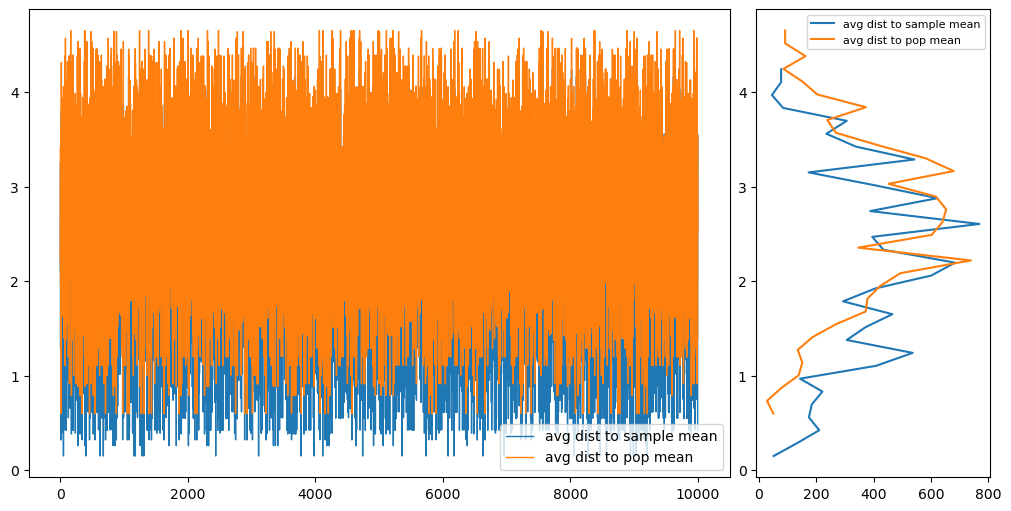

In [6]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(layout="constrained", figsize=(10, 5))

gs = GridSpec(1, 4, figure=fig)
ax1 = fig.add_subplot(gs[0, :3])
ax2 = fig.add_subplot(gs[0, 3])

df.plot.line(lw=1, ax=ax1)

for label, data in df.items():
    hist, bin_edges = np.histogram(data, bins=30)
    hist = np.append(hist, hist[-1])
    bottoms = np.zeros_like(hist)
    ax2.plot(hist, bin_edges, label=label)
    
ax2.legend(fontsize=8)


As we can see in the above graph, the average distance is lower in the computation with the sample mean, as expected.

Of course, the derivation of the correction for the bias (replacing $n$ by $n-1$) is another matter that I will not discuss here. 
I think it is fascinating that the needed correction is just this simple formula: adjusting the denominator to $n-1$.
I’m imagining how the correction could have been much more complicated, e.g. sample dependent or whatnot.

# TL;DR

$S_n^2 = \frac{1}{n} \sum_{i=1}^n (x_i - \bar{x})^2$ is a biased estimator of population variance based on the sample **because it uses $\bar{x}$ which introduces an error due to sampling itself (and not the unknown population mean $\mu$)**. Use $S_{n-1}^2 = \frac{1}{n-1} \sum_{i=1}^n (x_i - \bar{x})^2$ instead, in your goal is to have a better estimate of the population variance.


*This post was entirely written using the Jupyter Notebook. Its content is BSD-licensed. You can see a static view or download this notebook with the help of nbviewer at [20240130_variance_nminus1.ipynb](http://nbviewer.ipython.org/urls/raw.github.com/flothesof/posts/master/20240130_variance_nminus1.ipynb).*